<a href="https://colab.research.google.com/github/eterniacockers/BASH-Risk/blob/main/MDW_SVM_SMOTE_GBN_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by uploading the imputed data file.

Load LSTM data for testing a GBN.

In [ ]:
#Step 1.4.1 load data files
from google.colab import files
uploaded = files.upload()


Saving Full_CI_with_LSTM_XGB_Ensemble.csv to Full_CI_with_LSTM_XGB_Ensemble.csv
Saving MDW_LSTM_Preprocessed.csv to MDW_LSTM_Preprocessed.csv


I have to resample since none of the resmapled files saved properly. This will ensure the GBN runs on balanced data.

In [ ]:
# ✅ Step 2: Split into Training and Validation Sets (Colab Version)
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from google.colab import files


# ✅ Load the preprocessed datasets
lstm_file_path = "MDW_LSTM_Preprocessed.csv"

df_lstm = pd.read_csv(lstm_file_path)


# ✅ Convert DATE_and_Time to datetime (if not already)
df_lstm['DATE_and_Time'] = pd.to_datetime(df_lstm['DATE_and_Time'], errors='coerce')


# ✅ Ensure Risk_Category exists in LSTM dataset
if 'Risk_Category' not in df_lstm.columns:
    raise ValueError("❌ Risk_Category column is missing in LSTM dataset. Check preprocessing steps.")


# ✅ Split datasets into training (2015–2018) and validation (2019)
train_lstm = df_lstm[df_lstm['DATE_and_Time'].dt.year < 2019].reset_index(drop=True)
val_lstm = df_lstm[df_lstm['DATE_and_Time'].dt.year == 2019].reset_index(drop=True)

# ✅ Drop DATE_and_Time column after splitting
train_lstm.drop(columns=['DATE_and_Time'], inplace=True)
val_lstm.drop(columns=['DATE_and_Time'], inplace=True)


# ✅ Define function to create sequences for LSTM
def create_sequences(data, target, sequence_length=96):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].values  # Feature sequence
        y = target.iloc[i + sequence_length]  # Corresponding target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# ✅ Define sequence length for LSTM (96 time steps = 4 days)
sequence_length = 96

# ✅ Convert Risk_Category to integer before encoding for LSTM
train_lstm['Risk_Category'] = train_lstm['Risk_Category'].astype(int)
val_lstm['Risk_Category'] = val_lstm['Risk_Category'].astype(int)

# ✅ Separate features and target
features_train_lstm = train_lstm.drop(columns=['Risk_Category'])
target_train_lstm = train_lstm['Risk_Category']
features_val_lstm = val_lstm.drop(columns=['Risk_Category'])
target_val_lstm = val_lstm['Risk_Category']

# ✅ Create sequences for LSTM training and validation
X_train_lstm, y_train_lstm = create_sequences(features_train_lstm, target_train_lstm, sequence_length)
X_val_lstm, y_val_lstm = create_sequences(features_val_lstm, target_val_lstm, sequence_length)

# ✅ One-hot encode target variables for LSTM classification
num_classes = 3  # Explicitly set to 3 classes (Low, Moderate, Severe)
y_train_lstm = to_categorical(y_train_lstm, num_classes=num_classes)
y_val_lstm = to_categorical(y_val_lstm, num_classes=num_classes)

# ✅ Save processed LSTM data in Colab
np.save("X_train_LSTM.npy", X_train_lstm)
np.save("y_train_LSTM.npy", y_train_lstm)
np.save("X_val_LSTM.npy", X_val_lstm)
np.save("y_val_LSTM.npy", y_val_lstm)


# ✅ Print shapes for verification
print(f"✅ LSTM - X_train shape: {X_train_lstm.shape}, y_train shape: {y_train_lstm.shape}")
print(f"✅ LSTM - X_val shape: {X_val_lstm.shape}, y_val shape: {y_val_lstm.shape}")

# download file
files.download("X_train_LSTM.npy")
files.download("y_train_LSTM.npy")
files.download("X_val_LSTM.npy")
files.download("y_val_LSTM.npy")

✅ LSTM - X_train shape: (34852, 96, 15), y_train shape: (34852, 3)
✅ LSTM - X_val shape: (8664, 96, 15), y_val shape: (8664, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 Class distribution before SVM-SMOTE: Counter({np.int64(0): 19537, np.int64(1): 12987, np.int64(2): 2328})


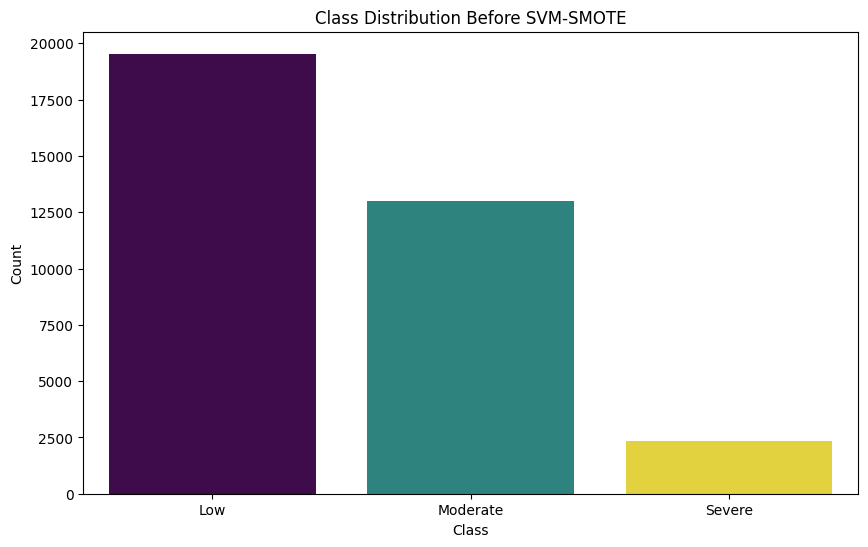

📊 Class distribution after SVM-SMOTE: Counter({np.int64(0): 19537, np.int64(1): 19537, np.int64(2): 19537})


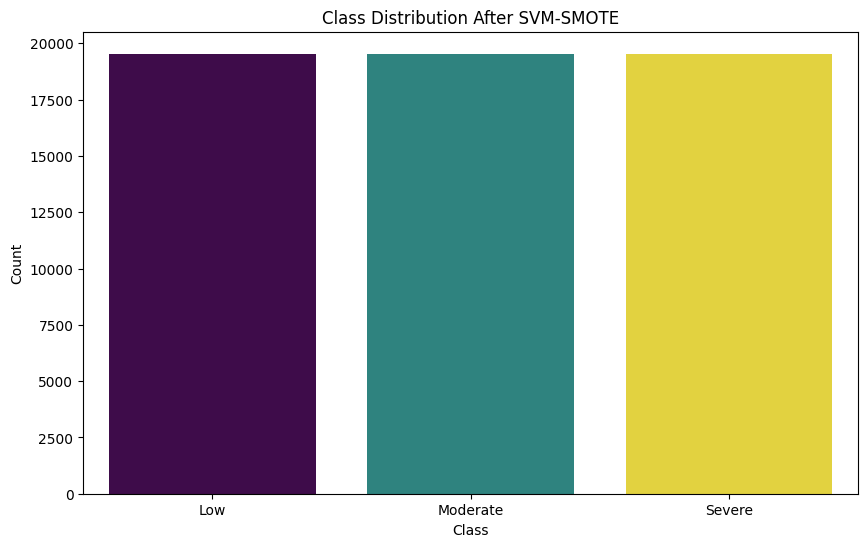

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Step 3: SVM-SMOTE for Target Balancing in LSTM (Colab Version)
from imblearn.over_sampling import SVMSMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from tensorflow.keras.utils import to_categorical

# ✅ Load processed training data
# ✅ Load processed training data with `allow_pickle=True`
X_train = np.load("X_train_LSTM.npy", allow_pickle=True)
y_train = np.load("y_train_LSTM.npy", allow_pickle=True)


# ✅ Flatten training features for SMOTE (Convert 3D → 2D)
train_features = X_train.reshape(X_train.shape[0], -1)  # Reshape to 2D for SMOTE
train_target = np.argmax(y_train, axis=1)  # Convert one-hot encoding to class labels

# ✅ Check class distribution before balancing
class_counts_before = collections.Counter(train_target)
print("📊 Class distribution before SVM-SMOTE:", class_counts_before)

# ✅ Plot class distribution before SMOTE
plt.figure(figsize=(10, 6))
sns.countplot(x=train_target, palette="viridis", hue=train_target, dodge=False)
plt.title("Class Distribution Before SVM-SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Low", "Moderate", "Severe"])
plt.legend([], [], frameon=False)
plt.show()

# ✅ Apply SVM-SMOTE to **only oversample** the minority classes
svm_smote = SVMSMOTE(sampling_strategy='auto', random_state=42)  # Auto ensures **only minority class upsampling**
train_features_resampled, train_target_resampled = svm_smote.fit_resample(train_features, train_target)

# ✅ Check class distribution after SVM-SMOTE
class_counts_after = collections.Counter(train_target_resampled)
print("📊 Class distribution after SVM-SMOTE:", class_counts_after)

# ✅ Plot class distribution after SVM-SMOTE
plt.figure(figsize=(10, 6))
sns.countplot(x=train_target_resampled, palette="viridis", hue=train_target_resampled, dodge=False)
plt.title("Class Distribution After SVM-SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Low", "Moderate", "Severe"])
plt.legend([], [], frameon=False)
plt.show()

# ✅ Get sequence length and feature count (Reshape back to 3D for LSTM)
sequence_length = X_train.shape[1]  # 96 time steps
num_features = X_train.shape[2]  # Number of features per timestep

train_features_resampled = train_features_resampled.reshape(-1, sequence_length, num_features)

# ✅ One-hot encode the resampled targets AFTER verifying balance
train_target_resampled = to_categorical(train_target_resampled, num_classes=3)

resample_method = "SVM_SMOTE"
np.save(f"X_train_{resample_method}.npy", train_features_resampled)
np.save(f"y_train_{resample_method}.npy", train_target_resampled)

files.download(f"X_train_{resample_method}.npy")
files.download(f"y_train_{resample_method}.npy")


In [ ]:
#2D for GBN
import numpy as np
import pandas as pd

# ✅ Load unbalanced validation data
X_val = np.load("X_val_LSTM.npy", allow_pickle=True)
y_val = np.load("y_val_LSTM.npy", allow_pickle=True)

# ✅ Load resampled training data (SVM-SMOTE in this case)
X_train = np.load("X_train_SVM_SMOTE.npy")
y_train = np.load("y_train_SVM_SMOTE.npy")

# ✅ Flatten for GBN input
# ✅ Correct: take only the final time step (t = -1)
X_train_flat = X_train[:, -1, :]  # shape: (n_samples, 15)
X_val_flat = X_val[:, -1, :]      # shape: (n_samples, 15)


y_train_flat = np.argmax(y_train, axis=1)
y_val_flat = np.argmax(y_val, axis=1)

# ✅ Define feature names (if using 15 original features)
feature_names = [
    'Wet_Bulb_Lag_2', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_2', 'Altimeter_Lag_3', 'Wind_Direction_Lag_2',
    'Risk_Low_Lag_2', 'Risk_Low_Lag_24', 'Risk_Moderate_Lag_2', 'Risk_Moderate_Lag_24',
    'Risk_Severe_Lag_2', 'Risk_Severe_Lag_24', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

# ✅ Map class index to label name
label_map = {0: "Low", 1: "Moderate", 2: "Severe"}
y_train_labels = pd.Series(y_train_flat).map(label_map)
y_val_labels = pd.Series(y_val_flat).map(label_map)

# ✅ Rebuild DataFrames
train_df = pd.DataFrame(X_train_flat, columns=feature_names)
train_df["Risk_Category"] = y_train_labels
train_df["Risk_Category_Encoded"] = y_train_flat

val_df = pd.DataFrame(X_val_flat, columns=feature_names)
val_df["Risk_Category"] = y_val_labels
val_df["Risk_Category_Encoded"] = y_val_flat




In [ ]:
# ✅ Step 4: Optimized Bayesian Bi-LSTM Model Training for Classification with LSTM Ensemble files (Colab Version) adjusted weight
# ✅ Import modeling and evaluation libraries
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np


# Define features and target
feature_cols = feature_names
X = train_df[feature_cols].values
y = train_df["Risk_Category_Encoded"].values

X_val_input = val_df[feature_cols].values
y_val_input = val_df["Risk_Category_Encoded"].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_val_scaled = scaler.transform(X_val_input)

# Train PyMC model
with pm.Model() as model:
    coeffs = pm.Normal("coeffs", mu=0, sigma=1, shape=(X_scaled.shape[1], 3))
    intercept = pm.Normal("intercept", mu=0, sigma=1, shape=(3,))
    logits = pm.math.dot(X_scaled, coeffs) + intercept
    y_obs = pm.Categorical("y_obs", logit_p=logits, observed=y)
    approx = pm.fit(method="advi", n=50000)
    trace = approx.sample(draws=1000)

# Posterior prediction without aesara
coeff_samples = trace.posterior["coeffs"].stack(sample=("chain", "draw")).values
intercept_samples = trace.posterior["intercept"].stack(sample=("chain", "draw")).values
coeff_samples = np.transpose(coeff_samples, (2, 0, 1))
intercept_samples = np.transpose(intercept_samples, (1, 0))
logits = np.einsum("sfc,nf->snc", coeff_samples, X_val_scaled) + intercept_samples[:, np.newaxis, :]
exp_logits = np.exp(logits - logits.max(axis=2, keepdims=True))
probs = exp_logits / exp_logits.sum(axis=2, keepdims=True)
mean_probs = probs.mean(axis=0)
y_pred = np.argmax(mean_probs, axis=1)

# Save predictions
val_df["PyMC_Predicted_Class"] = y_pred
for i, label in enumerate(["Low", "Moderate", "Severe"]):
    val_df[f"PyMC_Prob_{label}"] = mean_probs[:, i]
val_df.to_csv("cgbn_pymc_predictions.csv", index=False)




Output()

In [ ]:
# Step 4.1 save files
import arviz as az

# ✅ Save posterior trace
az.to_netcdf(trace, "cgbn_trace.nc")

# ✅ Save summary
summary = az.summary(trace, var_names=["coeffs", "intercept"])
summary.to_csv("cgbn_trace_summary.csv")

# ✅ Save predictions
val_df["PyMC_Predicted_Class"] = y_pred
for i, label in enumerate(["Low", "Moderate", "Severe"]):
    val_df[f"PyMC_Prob_{label}"] = mean_probs[:, i]
val_df.to_csv("cgbn_pymc_predictions.csv", index=False)

# ✅ Download all saved files from Colab
from google.colab import files
files.download("cgbn_trace.nc")
files.download("cgbn_trace_summary.csv")
files.download("cgbn_pymc_predictions.csv")

print("✅ Files saved and downloading now.")



Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files saved and downloading now.


Confusion Matrix:
[[3536  959  137]
 [ 691 2085  648]
 [  54  177  377]]

Classification Report:
              precision    recall  f1-score   support

         Low       0.83      0.76      0.79      4632
    Moderate       0.65      0.61      0.63      3424
      Severe       0.32      0.62      0.43       608

    accuracy                           0.69      8664
   macro avg       0.60      0.66      0.62      8664
weighted avg       0.72      0.69      0.70      8664


Accuracy Score:
0.6922899353647276

Sensitivity (Recall) by Class: [0.76338515 0.60893692 0.62006579]
Specificity by Class: [np.float64(0.8152281746031746), np.float64(0.783206106870229), np.float64(0.9025571002979146)]

✅ Overall Sensitivity (Macro Avg): 0.6641292840554569
✅ Overall Specificity (Macro Avg): 0.8336637939237727


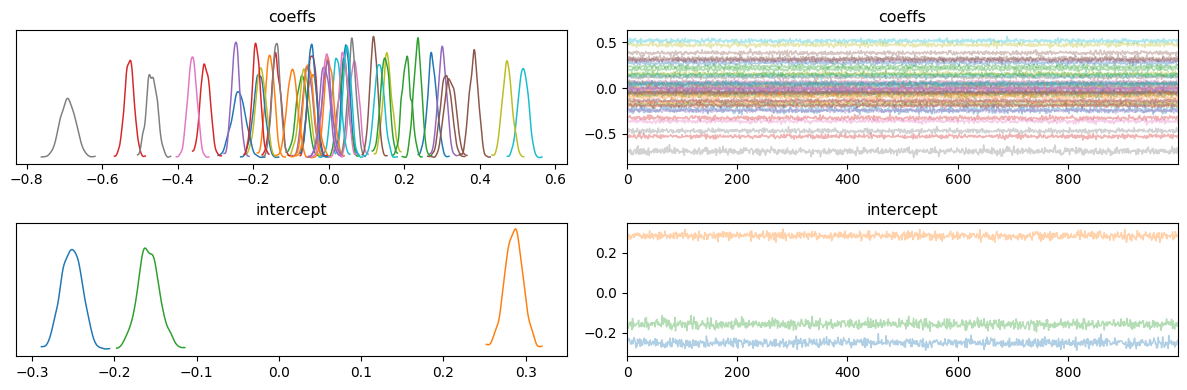

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


'cgbn_trace.nc'

In [ ]:
#Step 5 Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_val_input, y_pred)
print("Confusion Matrix:")
print(cm)

# ✅ Classification Report and Accuracy
print("\nClassification Report:")
print(classification_report(y_val_input, y_pred, target_names=["Low", "Moderate", "Severe"]))

print("\nAccuracy Score:")
print(accuracy_score(y_val_input, y_pred))

# ✅ Sensitivity (Recall) per class
sensitivity = cm.diagonal() / cm.sum(axis=1)
print("\nSensitivity (Recall) by Class:", sensitivity)

# ✅ Specificity per class
specificity = []
for i in range(len(cm)):
    true_negatives = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    false_positives = np.sum(np.delete(cm[:, i], i))
    specificity.append(true_negatives / (true_negatives + false_positives))
print("Specificity by Class:", specificity)

# ✅ Macro averages
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)
print("\n✅ Overall Sensitivity (Macro Avg):", overall_sensitivity)
print("✅ Overall Specificity (Macro Avg):", overall_specificity)

# ✅ Posterior trace plots
az.plot_trace(trace, var_names=["coeffs", "intercept"])
plt.tight_layout()
plt.show()

# ✅ Trace summary (optional repeat)
az.summary(trace, var_names=["coeffs", "intercept"])

# ✅ Save trace
az.to_netcdf(trace, "cgbn_trace.nc")



Had to change the validation method due to stochasticity caused by the bayesian sampling.

In [ ]:
# Step 5.1 Confidence intervals for the model

# Calculate 95% confidence intervals (2.5 and 97.5 percentiles)
lower_bound = np.percentile(probs, 2.5, axis=0)
upper_bound = np.percentile(probs, 97.5, axis=0)

# CI width per sample per class
ci_widths = upper_bound - lower_bound

# Average CI width by class
avg_ci_widths = ci_widths.mean(axis=0)
print("\n🔍 Average CI Widths:")
for i, label in enumerate(["Low", "Moderate", "Severe"]):
    print(f"{label}: {avg_ci_widths[i]:.4f}")

for i, label in enumerate(["Low", "Moderate", "Severe"]):
    val_df[f"{label}_CI_Lower"] = lower_bound[:, i]
    val_df[f"{label}_CI_Upper"] = upper_bound[:, i]
    val_df[f"{label}_CI_Width"] = ci_widths[:, i]

# Save updated file
val_df.to_csv("cgbn_pymc_predictions_with_CI.csv", index=False)




🔍 Average CI Widths:
Low: 0.0379
Moderate: 0.0445
Severe: 0.0260


In [ ]:
# Step 5.2 Add date and time
# Load GBN output
gbn_df = pd.read_csv("cgbn_pymc_predictions.csv")

# Load ensemble metadata (already aligned)
ensemble_df = pd.read_csv("Full_CI_with_LSTM_XGB_Ensemble.csv", parse_dates=["DATE_and_Time"])

# Add timestamps to GBN
gbn_df["DATE_and_Time"] = ensemble_df["DATE_and_Time"]


In [ ]:
# Step 5.2.1 Combine with LSTM and XGBoost files while adding date and time.
import google.colab.files

# Load GBN output
gbn_df = pd.read_csv("cgbn_pymc_predictions.csv")

# Load ensemble metadata (already aligned)
ensemble_df = pd.read_csv("Full_CI_with_LSTM_XGB_Ensemble.csv", parse_dates=["DATE_and_Time"])

# Add timestamps to GBN
gbn_df["DATE_and_Time"] = ensemble_df["DATE_and_Time"]
# probs: shape (n_samples, n_classes, n_post_samples)
# Already computed in GBN script: probs

lower = np.percentile(probs, 2.5, axis=0)
upper = np.percentile(probs, 97.5, axis=0)
mean_probs = probs.mean(axis=0)
ci_widths = upper - lower

# Assemble into CI DataFrame
ci_gbn = pd.DataFrame({
    "Mean Prediction (GBN Low)": mean_probs[:, 0],
    "Lower Bound (GBN Low 95% CI)": lower[:, 0],
    "Upper Bound (GBN Low 95% CI)": upper[:, 0],
    "GBN Low CI Width": ci_widths[:, 0],

    "Mean Prediction (GBN Moderate)": mean_probs[:, 1],
    "Lower Bound (GBN Moderate 95% CI)": lower[:, 1],
    "Upper Bound (GBN Moderate 95% CI)": upper[:, 1],
    "GBN Moderate CI Width": ci_widths[:, 1],

    "Mean Prediction (GBN Severe)": mean_probs[:, 2],
    "Lower Bound (GBN Severe 95% CI)": lower[:, 2],
    "Upper Bound (GBN Severe 95% CI)": upper[:, 2],
    "GBN Severe CI Width": ci_widths[:, 2]
})
# ✅ Load the existing full CI file
ci_full = pd.read_csv("Full_CI_with_LSTM_XGB_Ensemble.csv", parse_dates=["DATE_and_Time"])

# ✅ Merge on index (make sure lengths match)
assert len(ci_gbn) == len(ci_full), "Length mismatch between GBN and Ensemble CI!"
ci_full = pd.concat([ci_full, ci_gbn.reset_index(drop=True)], axis=1)

# ✅ Save updated file
ci_full.to_csv("Full_CI_with_LSTM_XGB_Ensemble_GBN.csv", index=False)
print("✅ Combined CI with GBN saved.")
google.colab.files.download("Full_CI_with_LSTM_XGB_Ensemble_GBN.csv")

print("\n🔍 Avg CI Widths — GBN")
print("Low:", ci_gbn["GBN Low CI Width"].mean())
print("Moderate:", ci_gbn["GBN Moderate CI Width"].mean())
print("Severe:", ci_gbn["GBN Severe CI Width"].mean())


✅ Combined CI with GBN saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🔍 Avg CI Widths — GBN
Low: 0.0379000381653888
Moderate: 0.04453692499280583
Severe: 0.026021434707395767


📌 Bayesian Model Structure (PyMC Graph)


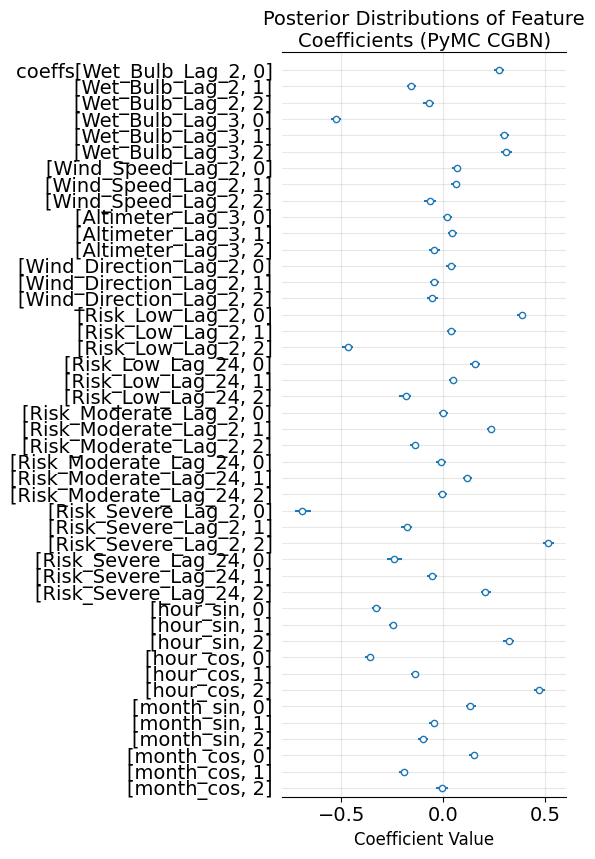

In [ ]:

# ✅ Step 6: Visualize Bayesian Model Structure & Coefficient Effects
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import graphviz

# ✅ PyMC Computational Graph (Model Structure)
print("📌 Bayesian Model Structure (PyMC Graph)")
pm.model_to_graphviz(model)  # This will render directly in Colab

# ✅ Rename coefficient dimensions for clean forest plot
# This adds actual feature names as coordinates for display
trace = trace.assign_coords({"coeffs_dim_0": feature_names})

# ✅ Posterior Coefficient Effects (Forest Plot)
# ✅ Plot posterior distributions for coefficients
az.plot_forest(
    trace,
    var_names=["coeffs"],
    combined=True,
    hdi_prob=0.95,  # replaces credible_interval
    ridgeplot_overlap=2,
    colors="cycle"
)
plt.title("Posterior Distributions of Feature Coefficients (PyMC CGBN)", fontsize=14)
plt.xlabel("Coefficient Value", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




<ipython-input-13-657aec2c4909>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


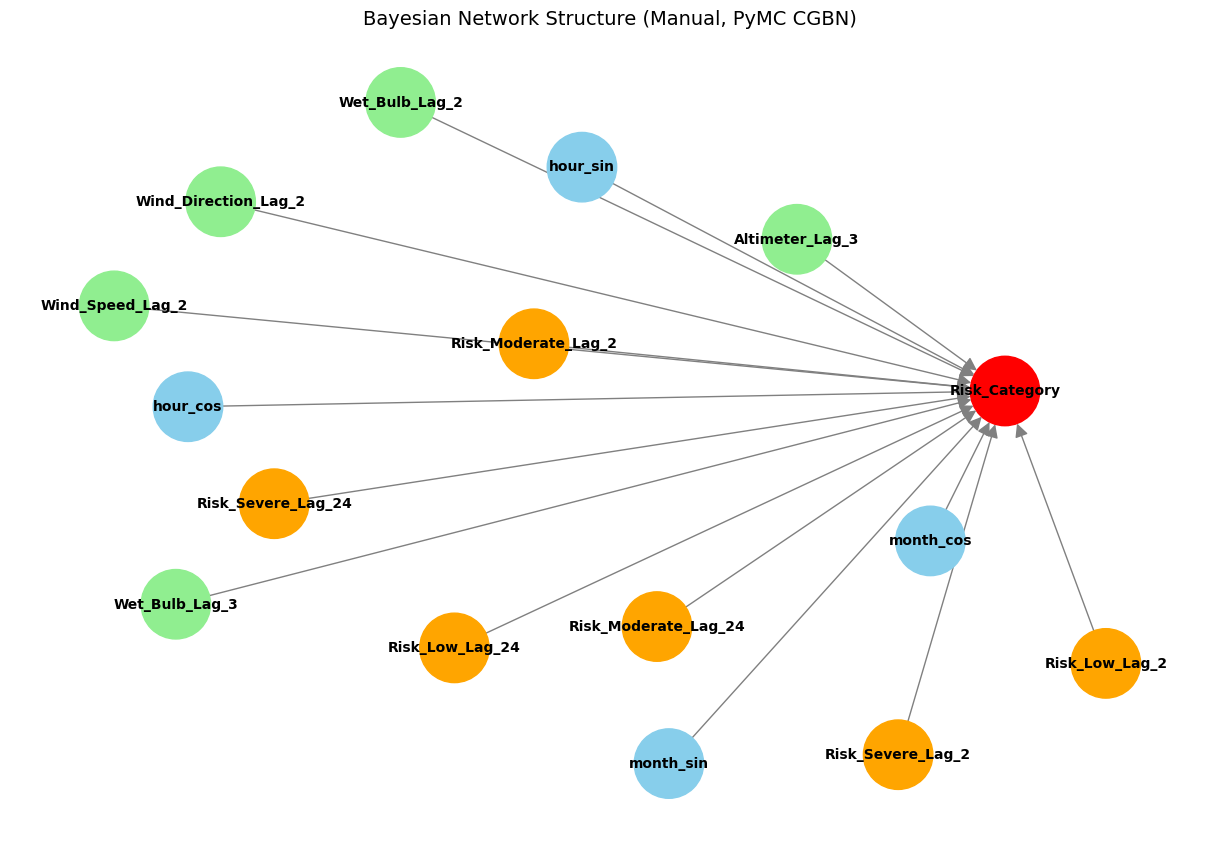

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# ✅ Manual edge list based on temporal + model dependencies
edges = [
    ("Wet_Bulb_Lag_2", "Risk_Category"),
    ("Wet_Bulb_Lag_3", "Risk_Category"),
    ("Wind_Speed_Lag_2", "Risk_Category"),
    ("Altimeter_Lag_3", "Risk_Category"),
    ("Wind_Direction_Lag_2", "Risk_Category"),

    ("Risk_Low_Lag_2", "Risk_Category"),
    ("Risk_Low_Lag_24", "Risk_Category"),
    ("Risk_Moderate_Lag_2", "Risk_Category"),
    ("Risk_Moderate_Lag_24", "Risk_Category"),
    ("Risk_Severe_Lag_2", "Risk_Category"),
    ("Risk_Severe_Lag_24", "Risk_Category"),

    ("hour_sin", "Risk_Category"),
    ("hour_cos", "Risk_Category"),
    ("month_sin", "Risk_Category"),
    ("month_cos", "Risk_Category")
]

# ✅ Create and style the graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Node styling
node_colors = []
for node in G.nodes():
    if "Risk_" in node and "Lag" in node:
        node_colors.append("orange")  # Past risk lags
    elif "Wet_Bulb" in node or "Wind" in node or "Altimeter" in node:
        node_colors.append("lightgreen")  # Meteorological
    elif "hour" in node or "month" in node:
        node_colors.append("skyblue")  # Temporal features
    elif node == "Risk_Category":
        node_colors.append("red")  # Target
    else:
        node_colors.append("gray")

# Layout
pos = nx.spring_layout(G, k=0.6, seed=42)

# Draw
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    node_size=2500,
    font_size=10,
    font_weight='bold',
    edge_color="gray",
    arrows=True,
    arrowstyle='-|>',
    arrowsize=20
)
plt.title("Bayesian Network Structure (Manual, PyMC CGBN)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Step 7: Evaluate GBN Risk Estimates (clean version)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ Map encoded risk levels to human-readable labels
label_map = {0: "Low", 1: "Moderate", 2: "Severe"}
val_df["Actual_Risk_Label"] = val_df["Risk_Category_Encoded"].map(label_map)
val_df["Predicted_Risk_Label"] = val_df["PyMC_Predicted_Class"].map(label_map)

# ✅ Drop any rows with missing labels (just in case)
filtered_df = val_df.dropna(subset=["Actual_Risk_Label", "Predicted_Risk_Label"])

# ✅ Extract labels
y_true = filtered_df["Actual_Risk_Label"]
y_pred = filtered_df["Predicted_Risk_Label"]
labels = ["Low", "Moderate", "Severe"]




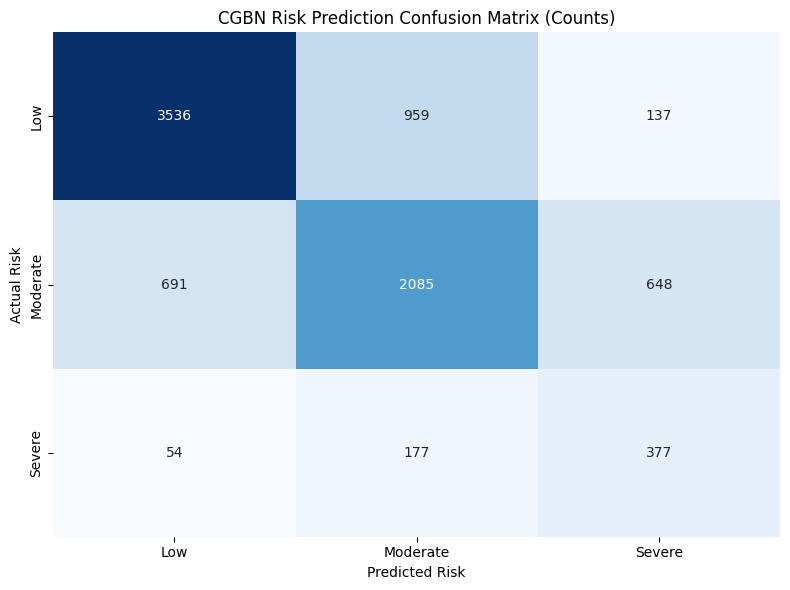

In [ ]:
#Step 7.3.1
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("CGBN Risk Prediction Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()


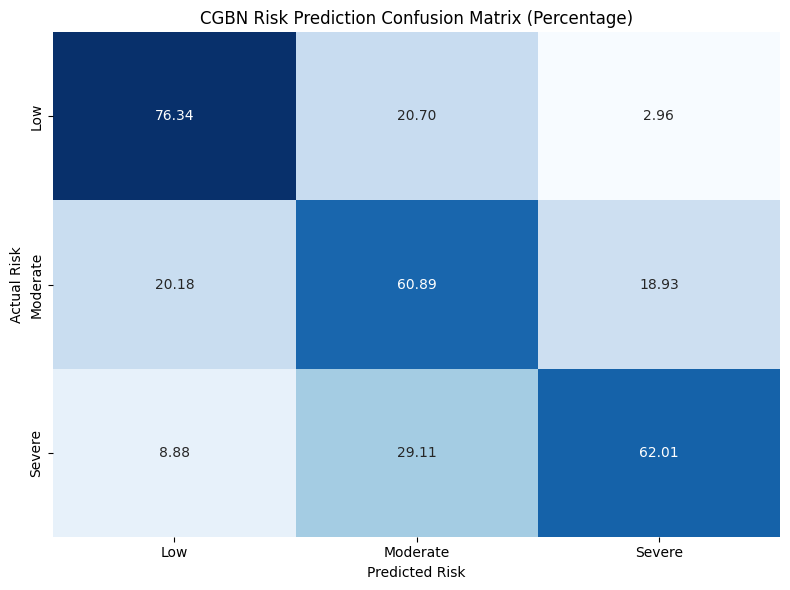

In [ ]:
#Step 7.3.2
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]*100
cm_percent_df = pd.DataFrame(cm_percent, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("CGBN Risk Prediction Confusion Matrix (Percentage)")
plt.tight_layout()
plt.show()


In [ ]:
#Step 7.3.3
print("📊 CGBN Risk Classification Report:")
print(classification_report(y_true, y_pred, labels=labels))


📊 CGBN Risk Classification Report:
              precision    recall  f1-score   support

         Low       0.83      0.76      0.79      4632
    Moderate       0.65      0.61      0.63      3424
      Severe       0.32      0.62      0.43       608

    accuracy                           0.69      8664
   macro avg       0.60      0.66      0.62      8664
weighted avg       0.72      0.69      0.70      8664



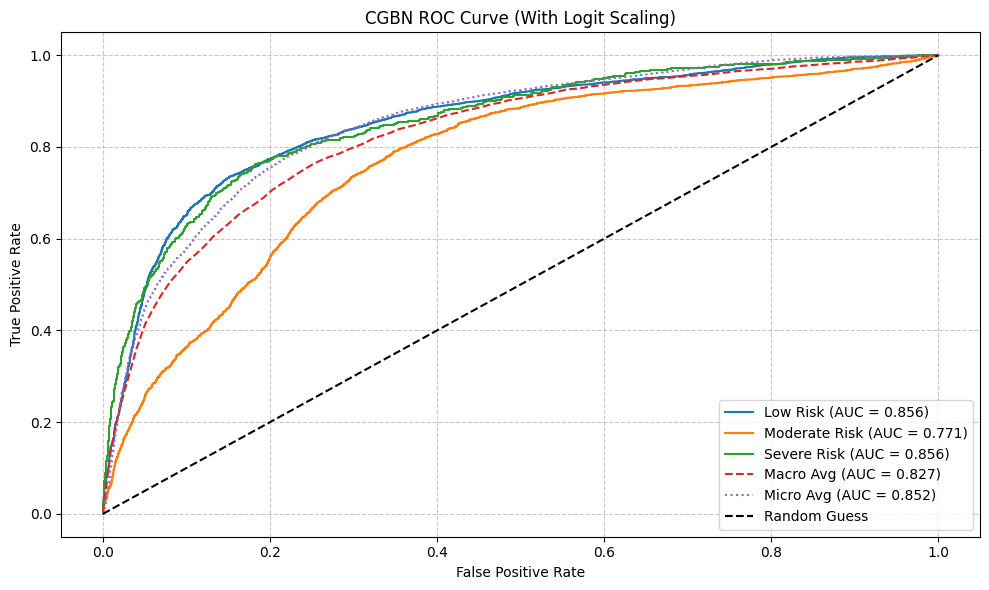

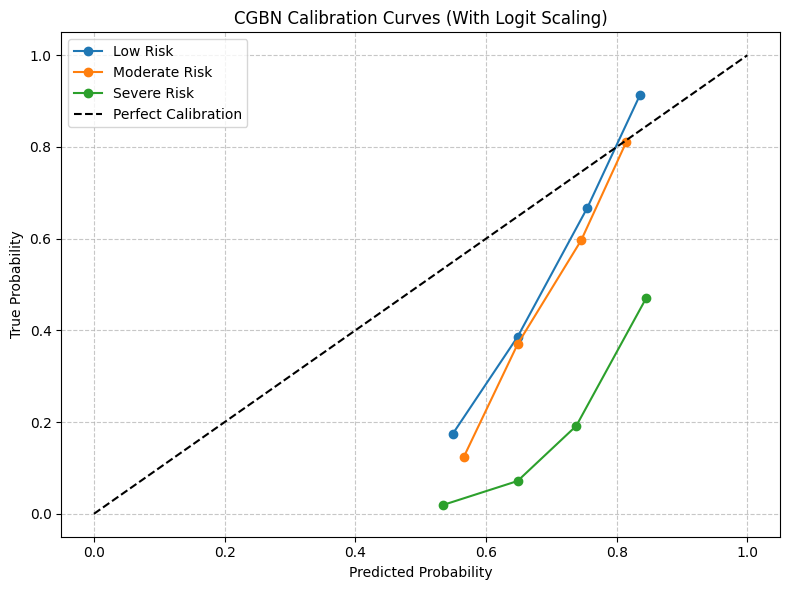

In [ ]:
# Step 8: ROC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

# Convert predicted probabilities from mean_probs (shape: [n_samples, 3])
y_pred_probs = mean_probs.copy()  # already normalized softmax from trace

# Convert true class labels (0 = Low, 1 = Moderate, 2 = Severe)
y_true_classes = val_df["Risk_Category_Encoded"].values

# One-hot encode true labels for ROC
y_true_bin = label_binarize(y_true_classes, classes=[0, 1, 2])

# Optional: apply logit scaling to probabilities (can help smooth ROC curves)
y_pred_probs_scaled = scipy.special.expit(y_pred_probs * 2)  # Adjust the scale factor if needed

# Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(["Low", "Moderate", "Severe"]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs_scaled[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(len(fpr)):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= len(fpr)
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_probs_scaled.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(10, 6))

for i, label in enumerate(["Low", "Moderate", "Severe"]):
    plt.plot(fpr[i], tpr[i], label=f"{label} Risk (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr_macro, tpr_macro, linestyle='dashed', label=f"Macro Avg (AUC = {roc_auc_macro:.3f})")
plt.plot(fpr_micro, tpr_micro, linestyle='dotted', label=f"Micro Avg (AUC = {roc_auc_micro:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CGBN ROC Curve (With Logit Scaling)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

for i, class_name in enumerate(["Low", "Moderate", "Severe"]):
    y_true_binary = (y_true_classes == i).astype(int)
    prob_true, prob_pred = calibration_curve(y_true_binary, y_pred_probs_scaled[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"{class_name} Risk")

plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("CGBN Calibration Curves (With Logit Scaling)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Added probability calibration for the BRNN

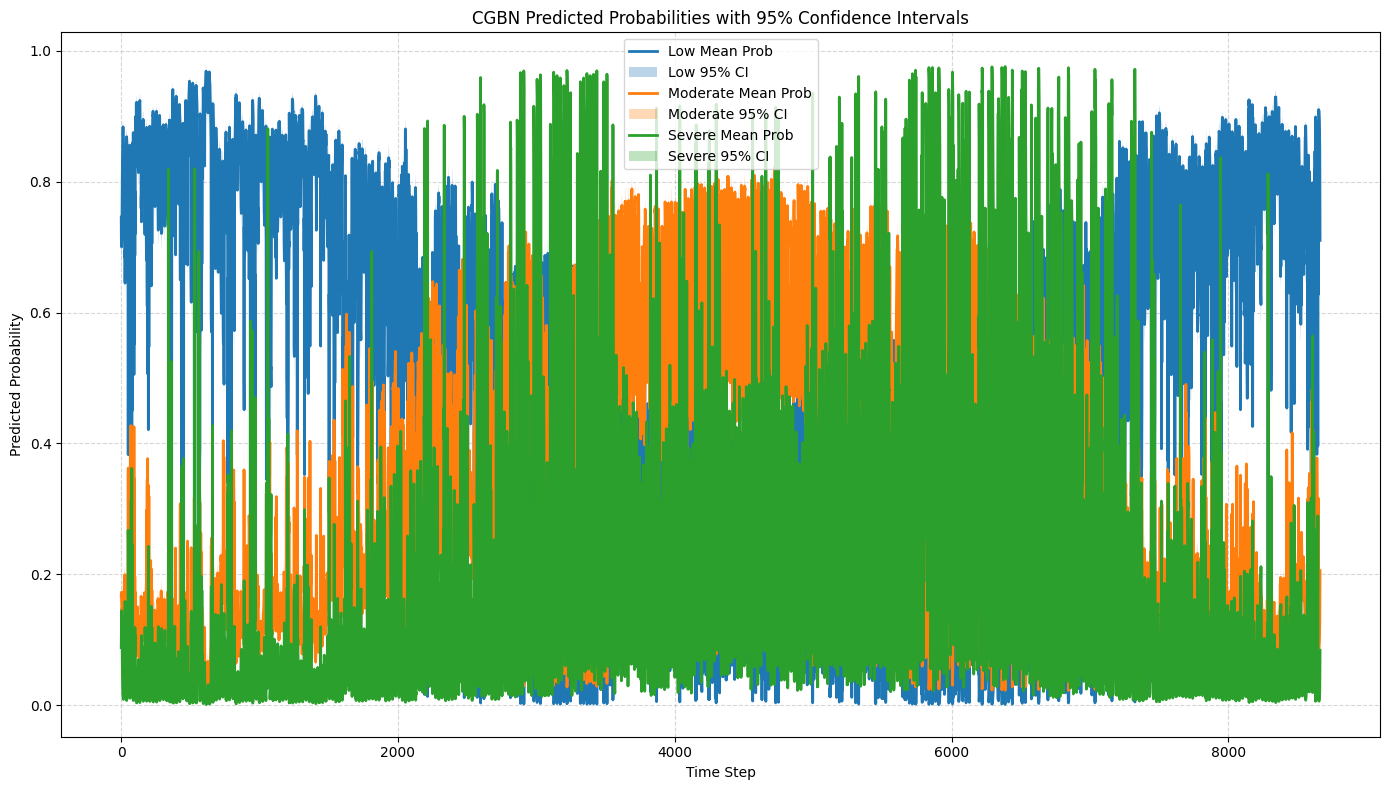

In [ ]:
#Step 9.1 confidence interval
import numpy as np
import matplotlib.pyplot as plt

# Calculate 95% credible intervals from posterior predictive samples
# probs shape: [num_samples, num_timesteps, num_classes]
lower_ci = np.percentile(probs, 2.5, axis=0)   # shape: [n_time, n_class]
upper_ci = np.percentile(probs, 97.5, axis=0)
mean_probs = probs.mean(axis=0)                # already used for y_pred

# Plot confidence bands per class
classes = ["Low", "Moderate", "Severe"]
timesteps = np.arange(mean_probs.shape[0])

plt.figure(figsize=(14, 8))
for i, label in enumerate(classes):
    plt.plot(timesteps, mean_probs[:, i], label=f"{label} Mean Prob", linewidth=2)
    plt.fill_between(
        timesteps,
        lower_ci[:, i],
        upper_ci[:, i],
        alpha=0.3,
        label=f"{label} 95% CI"
    )

plt.xlabel("Time Step")
plt.ylabel("Predicted Probability")
plt.title("CGBN Predicted Probabilities with 95% Confidence Intervals")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



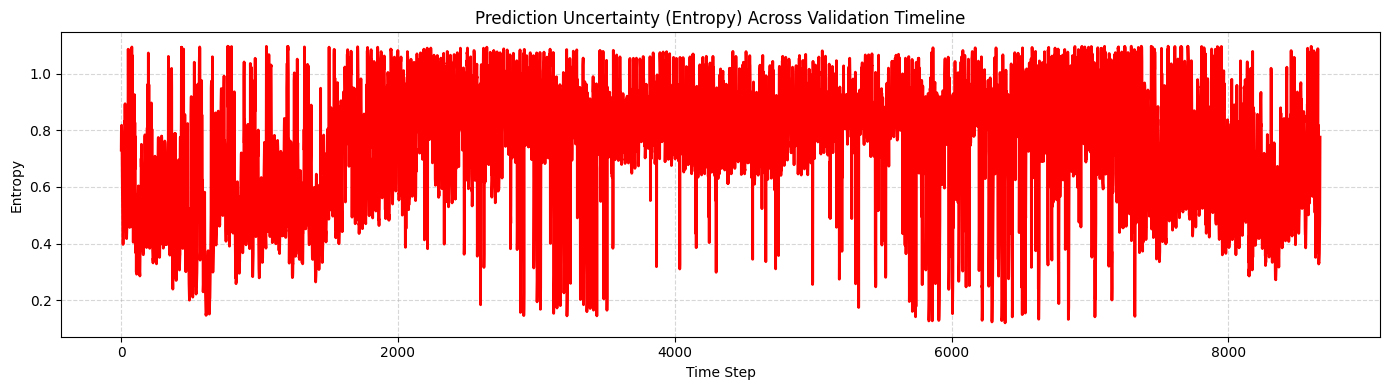

In [ ]:
from scipy.stats import entropy

# Compute entropy per timestep (higher = less confident)
uncertainty = entropy(mean_probs.T)  # shape: [n_timesteps]

plt.figure(figsize=(14, 4))
plt.plot(timesteps, uncertainty, color='red', linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("Entropy")
plt.title("Prediction Uncertainty (Entropy) Across Validation Timeline")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Create a three tier ensemble with CGBN, LSTM, and XGBoost for IAH SVM SMOTE only.

In [ ]:
#Ensemble step 1, load files
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load XGBoost predictions and ground truth
xgb_df = pd.read_csv("val_XGBoost_with_Categorical_Risk_with_date.csv")

# Load LSTM predictions
lstm_preds = np.load("lstm_preds.npy")

# Load CGBN predictions
cgbn_df = pd.read_csv("cgbn_pymc_predictions.csv")  # or cgbn_val_df_with_probs.csv


In [ ]:
print(f"LSTM predictions:      {len(lstm_preds)}")
print(f"XGBoost predictions:   {len(xgb_df)}")
print(f"CGBN predictions:      {len(cgbn_df)}")


LSTM predictions:      8664
XGBoost predictions:   8664
CGBN predictions:      8664


In [ ]:
#Trim XGBoost to match LSTM and CGBN
xgb_df = xgb_df.iloc[:8664].reset_index(drop=True)

In [ ]:
print(xgb_df.columns.tolist())


['Max_Risk_Quartile', 'Max_Risk_Quartile_Lag_2', 'Max_Risk_Quartile_Lag_24', 'Wet_Bulb_Lag_2', 'Wet_Bulb_Lag_3', 'Wind_Speed_Lag_2', 'Altimeter_Lag_3', 'Wind_Direction_Lag_2', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'Max_Risk', 'Predicted_Max_Risk', 'Actual_Risk', 'Predicted_Risk', 'DATE_and_Time']


In [ ]:
val_xgb = pd.read_csv("val_XGBoost_with_Categorical_Risk_with_date.csv")



In [ ]:
# Use the numeric predictions directly
xgb_probs_trimmed = np.zeros((len(val_xgb), 3))
for i, pred in enumerate(val_xgb["Predicted_Risk"]):
    xgb_probs_trimmed[i, int(pred)] = 1


In [ ]:
print(xgb_probs_trimmed.shape)  # Should be (8760, 3)


(8664, 3)


In [ ]:
xgb_probs_trimmed = xgb_probs_trimmed[-8664:]


In [ ]:
lstm_preds = np.load("lstm_preds.npy")
lstm_probs = np.zeros((len(lstm_preds), 3))
for i, pred in enumerate(lstm_preds):
    lstm_probs[i, int(pred)] = 1


In [ ]:
import numpy as np

# Load true labels for evaluation
y_val_lstm = np.load("y_val_LSTM.npy", allow_pickle=True)
y_val_lstm_labels = np.argmax(y_val_lstm, axis=1)  # Convert from one-hot to class indices

print("✅ Loaded y_val_lstm_labels:", y_val_lstm_labels.shape)


✅ Loaded y_val_lstm_labels: (8664,)


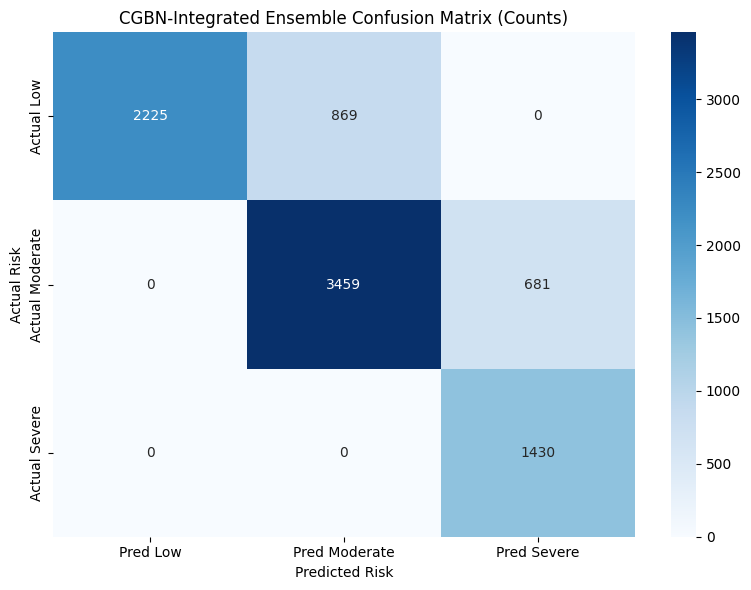

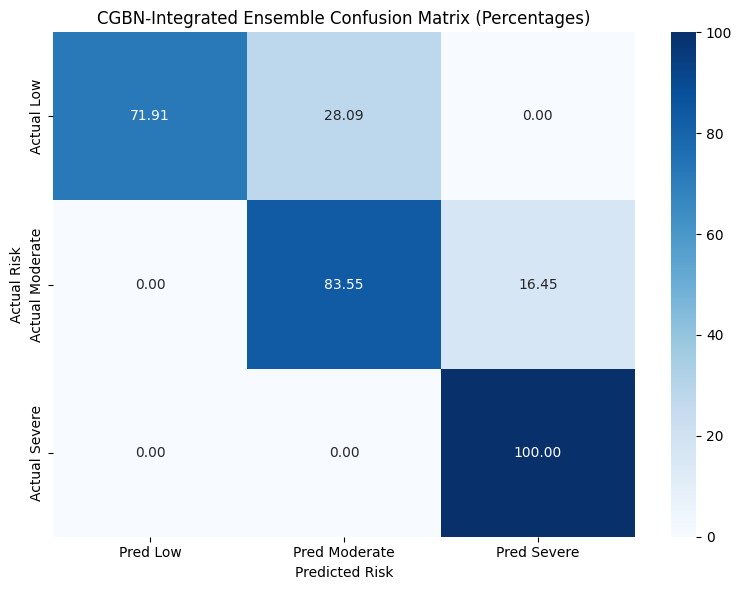

✅ Ensemble Accuracy (CGBN integrated): 82.1099%
✅ Ensemble Classification Report:
               precision    recall  f1-score   support

         Low       1.00      0.72      0.84      3094
    Moderate       0.80      0.84      0.82      4140
      Severe       0.68      1.00      0.81      1430

    accuracy                           0.82      8664
   macro avg       0.83      0.85      0.82      8664
weighted avg       0.85      0.82      0.82      8664



In [ ]:
#Step 2, Buld the ensemble:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Step 1: Confirm probability arrays are aligned
# lstm_probs: (8664, 3)
# xgb_probs_trimmed: (8664, 3)
# mean_probs (CGBN): (8664, 3)

# Step 2: Weighted Ensemble Averaging
ensemble_probs = (
    0.50 * xgb_probs_trimmed +
    0.30 * lstm_probs +
    0.2 * mean_probs
)

# Step 3: Convert to class predictions
final_preds = np.argmax(ensemble_probs, axis=1)

# Step 4: True labels from LSTM validation set
y_val_lstm_labels = np.argmax(y_val_lstm, axis=1)

# Step 5: Evaluation
ensemble_accuracy = accuracy_score(y_val_lstm_labels, final_preds)
ensemble_cm = confusion_matrix(y_val_lstm_labels, final_preds)
ensemble_report = classification_report(y_val_lstm_labels, final_preds, target_names=["Low", "Moderate", "Severe"])

# Step 6: Confusion Matrix Heatmaps
cm_df = pd.DataFrame(ensemble_cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                     columns=["Pred Low", "Pred Moderate", "Pred Severe"])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("CGBN-Integrated Ensemble Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

# Normalized percentages
cm_percent = ensemble_cm.astype(float) / ensemble_cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent_df = pd.DataFrame(cm_percent, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                             columns=["Pred Low", "Pred Moderate", "Pred Severe"])

plt.figure(figsize=(8,6))
sns.heatmap(cm_percent_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.title("CGBN-Integrated Ensemble Confusion Matrix (Percentages)")
plt.tight_layout()
plt.show()

# Step 7: Report
print(f"✅ Ensemble Accuracy (CGBN integrated): {ensemble_accuracy:.4%}")
print("✅ Ensemble Classification Report:\n", ensemble_report)



In [ ]:
#Ensemble 2.1, using entropy
from scipy.stats import entropy
import numpy as np

# mean_probs = CGBN's softmax probability predictions (shape: [8664, 3])
cgbn_entropy = entropy(mean_probs.T)  # shape: (8664,)

# Normalize entropy to range [0, 1]
cgbn_entropy_norm = (cgbn_entropy - cgbn_entropy.min()) / (cgbn_entropy.max() - cgbn_entropy.min())

# Invert entropy to get confidence weights: higher confidence → higher weight
cgbn_confidence_weights = 1 - cgbn_entropy_norm


In [ ]:
#2.2 Rebuild probabilities
# One-hot LSTM
lstm_probs = np.zeros((len(lstm_preds), 3))
for i, pred in enumerate(lstm_preds):
    lstm_probs[i, int(pred)] = 1

# One-hot XGBoost
xgb_probs = np.zeros((len(val_xgb), 3))
for i, pred in enumerate(val_xgb["Predicted_Risk"]):
    xgb_probs[i, int(pred)] = 1

# Trim to match LSTM/CGBN if needed
xgb_probs = xgb_probs[-8664:]


In [ ]:
#2.3 Create entropy weighted ensemble
# Fixed weights
w_lstm = 0.30
w_xgb = 0.50

# Final weight for each sample = 1 - fixed weights
w_cgbn = 1.0 - (w_lstm + w_xgb)  # Should be 0.20 if w_lstm=0.30, w_xgb=0.50

# Apply entropy-based scaling to CGBN
weighted_cgbn = (cgbn_confidence_weights * w_cgbn)[:, np.newaxis] * mean_probs

# Broadcast constant weights
weighted_lstm = w_lstm * lstm_probs
weighted_xgb = w_xgb * xgb_probs

# Final entropy-weighted ensemble
ensemble_probs = weighted_lstm + weighted_xgb + weighted_cgbn
final_preds = np.argmax(ensemble_probs, axis=1)


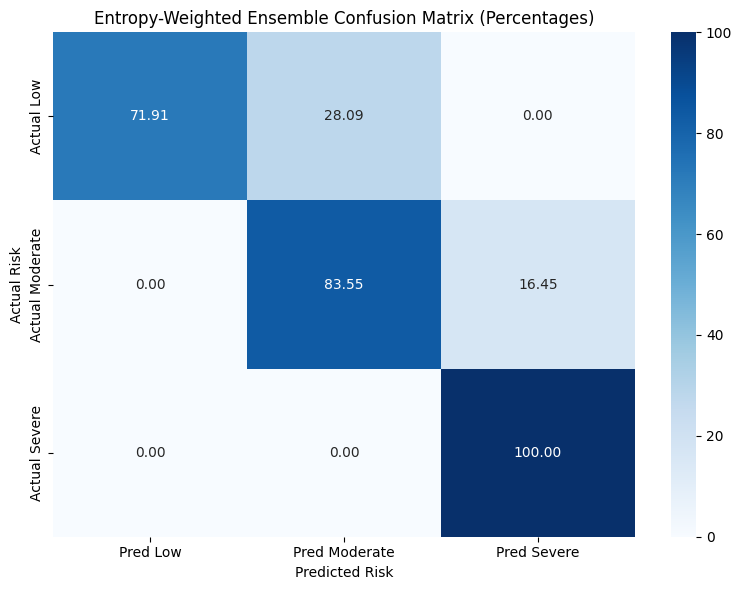

✅ Entropy-Weighted Ensemble Accuracy: 82.1099%
✅ Classification Report:
               precision    recall  f1-score   support

         Low       1.00      0.72      0.84      3094
    Moderate       0.80      0.84      0.82      4140
      Severe       0.68      1.00      0.81      1430

    accuracy                           0.82      8664
   macro avg       0.83      0.85      0.82      8664
weighted avg       0.85      0.82      0.82      8664



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# True labels (from LSTM validation)
y_val_lstm_labels = np.argmax(y_val_lstm, axis=1)

# Accuracy
accuracy = accuracy_score(y_val_lstm_labels, final_preds)

# Confusion Matrix
cm = confusion_matrix(y_val_lstm_labels, final_preds)
cm_df = pd.DataFrame(cm, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                     columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# Report
report = classification_report(y_val_lstm_labels, final_preds, target_names=["Low", "Moderate", "Severe"])

# Heatmap (Percent)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent_df = pd.DataFrame(cm_percent, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                             columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_percent_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Entropy-Weighted Ensemble Confusion Matrix (Percentages)")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.tight_layout()
plt.show()

# Final Printout
print(f"✅ Entropy-Weighted Ensemble Accuracy: {accuracy:.4%}")
print("✅ Classification Report:\n", report)


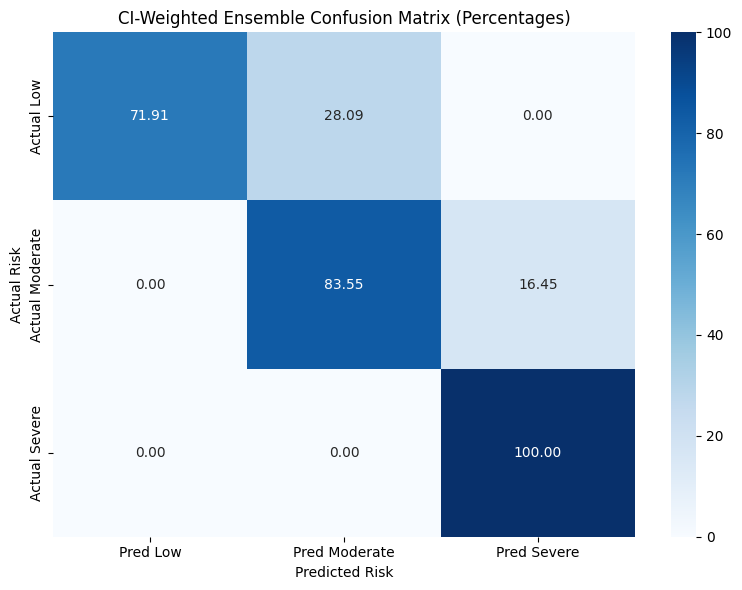

✅ CI-Weighted Ensemble Accuracy: 82.1099%
✅ Classification Report:
               precision    recall  f1-score   support

         Low       1.00      0.72      0.84      3094
    Moderate       0.80      0.84      0.82      4140
      Severe       0.68      1.00      0.81      1430

    accuracy                           0.82      8664
   macro avg       0.83      0.85      0.82      8664
weighted avg       0.85      0.82      0.82      8664



In [ ]:
#Ensemble 3, weighted voting, automated
# Use Severe CI width (or Moderate/Low based on class focus)
ci_width = ci_results_cgbn["Severe CI Width"].values  # shape (8664,)
normalized_ci_width = (ci_width - ci_width.min()) / (ci_width.max() - ci_width.min())

# Invert to get confidence weight: narrower CI → higher confidence
cgbn_conf_weight = 1 - normalized_ci_width  # shape (8664,)
cgbn_conf_weight = np.clip(cgbn_conf_weight, 0, 1)  # Safety clamp

w_lstm = 0.30
w_xgb = 0.50
max_w_cgbn = 0.20  # Max weight CGBN can contribute

# Broadcast fixed weights
weighted_lstm = w_lstm * lstm_probs
weighted_xgb = w_xgb * xgb_probs_trimmed

# Dynamically scale CGBN per sample
weighted_cgbn = (cgbn_conf_weight * max_w_cgbn)[:, np.newaxis] * mean_probs

# Combine ensemble
ensemble_probs_ci = weighted_lstm + weighted_xgb + weighted_cgbn
final_preds_ci = np.argmax(ensemble_probs_ci, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ground truth labels
y_true = np.argmax(y_val_lstm, axis=1)

# Accuracy
acc = accuracy_score(y_true, final_preds_ci)

# Confusion Matrix
cm = confusion_matrix(y_true, final_preds_ci)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent_df = pd.DataFrame(cm_percent, index=["Actual Low", "Actual Moderate", "Actual Severe"],
                             columns=["Pred Low", "Pred Moderate", "Pred Severe"])

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("CI-Weighted Ensemble Confusion Matrix (Percentages)")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.tight_layout()
plt.show()

# Report
print(f"✅ CI-Weighted Ensemble Accuracy: {acc:.4%}")
print("✅ Classification Report:\n", classification_report(y_true, final_preds_ci, target_names=["Low", "Moderate", "Severe"]))


In [ ]:
#Bootstrap confidence intervals
raw_df = pd.read_excel("MDW_Data_Python_Imputed.xlsx", parse_dates=["DATE_and_Time"])
val_timestamps = val_xgb["DATE_and_Time"][-min_len:]
meta_metadata = raw_df[raw_df["DATE_and_Time"].isin(val_timestamps)].sort_values("DATE_and_Time").reset_index(drop=True)
meta_metadata = meta_metadata[-min_len:]


<ipython-input-69-e67fe6584bb6>:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  meta_metadata = raw_df[raw_df["DATE_and_Time"].isin(val_timestamps)].sort_values("DATE_and_Time").reset_index(drop=True)


In [ ]:
ci_with_meta_cgbn = pd.concat([meta_metadata.reset_index(drop=True), ci_results_cgbn.reset_index(drop=True)], axis=1)


In [ ]:
# Reload metadata file
raw_df = pd.read_excel("MDW_Data_Python_Imputed.xlsx", parse_dates=["DATE_and_Time"])

# Use aligned timestamps from val_xgb
val_timestamps = val_xgb["DATE_and_Time"][-min_len:]

# Filter and align metadata
meta_metadata = raw_df[raw_df["DATE_and_Time"].isin(val_timestamps)].sort_values("DATE_and_Time").reset_index(drop=True)
meta_metadata = meta_metadata[-min_len:]


<ipython-input-71-899265e0a9ca>:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  meta_metadata = raw_df[raw_df["DATE_and_Time"].isin(val_timestamps)].sort_values("DATE_and_Time").reset_index(drop=True)


In [ ]:
# Step X: Bootstrap Confidence Intervals for CGBN Ensemble (LSTM + XGB + CGBN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Weights for the CGBN-integrated ensemble
w_lstm = 0.30
w_xgb = 0.50
w_cgbn = 0.20
n_bootstraps = 1000
min_len = 8664  # Match alignment with previous ensemble

# ✅ Initialize accumulators
sum_preds = np.zeros((min_len, 3), dtype=np.float32)
sum_preds_sq = np.zeros((min_len, 3), dtype=np.float32)

# ✅ Bootstrap loop
for i in range(n_bootstraps):
    indices = np.random.choice(min_len, size=min_len, replace=True)
    sampled_lstm = lstm_probs[indices]
    sampled_xgb = xgb_probs_trimmed[indices]
    sampled_cgbn = mean_probs[indices]

    preds_ensemble = (
        w_lstm * sampled_lstm +
        w_xgb * sampled_xgb +
        w_cgbn * sampled_cgbn
    )

    sum_preds += preds_ensemble
    sum_preds_sq += preds_ensemble**2

    if i % 100 == 0:
        print(f"✅ Bootstrap iteration {i}/{n_bootstraps}")

# ✅ Compute mean, std, and 95% CI bounds
mean_preds = sum_preds / n_bootstraps
std_preds = np.sqrt((sum_preds_sq / n_bootstraps) - (mean_preds**2))

lower_bound = np.clip(mean_preds - 1.96 * std_preds, 0, 1)
upper_bound = np.clip(mean_preds + 1.96 * std_preds, 0, 1)
ci_widths = upper_bound - lower_bound

# ✅ Create CI result DataFrame
ci_results_cgbn = pd.DataFrame({
    "Mean Prediction (Low Risk)": mean_preds[:, 0],
    "Lower Bound (Low 95% CI)": lower_bound[:, 0],
    "Upper Bound (Low 95% CI)": upper_bound[:, 0],
    "Low CI Width": ci_widths[:, 0],

    "Mean Prediction (Moderate Risk)": mean_preds[:, 1],
    "Lower Bound (Moderate 95% CI)": lower_bound[:, 1],
    "Upper Bound (Moderate 95% CI)": upper_bound[:, 1],
    "Moderate CI Width": ci_widths[:, 1],

    "Mean Prediction (Severe Risk)": mean_preds[:, 2],
    "Lower Bound (Severe 95% CI)": lower_bound[:, 2],
    "Upper Bound (Severe 95% CI)": upper_bound[:, 2],
    "Severe CI Width": ci_widths[:, 2]
})

# ✅ Merge with metadata (from your earlier load)
ci_with_meta_cgbn = pd.concat([meta_metadata.reset_index(drop=True), ci_results_cgbn.reset_index(drop=True)], axis=1)

# ✅ Save result
save_path = "CGBN_Ensemble_Bootstrapped_CI_with_Metadata.csv"
ci_with_meta_cgbn.to_csv(save_path, index=False)
print(f"\n✅ Saved CGBN Ensemble CI + Metadata to: {save_path}")


✅ Bootstrap iteration 0/1000
✅ Bootstrap iteration 100/1000
✅ Bootstrap iteration 200/1000
✅ Bootstrap iteration 300/1000
✅ Bootstrap iteration 400/1000
✅ Bootstrap iteration 500/1000
✅ Bootstrap iteration 600/1000
✅ Bootstrap iteration 700/1000
✅ Bootstrap iteration 800/1000
✅ Bootstrap iteration 900/1000

✅ Saved CGBN Ensemble CI + Metadata to: CGBN_Ensemble_Bootstrapped_CI_with_Metadata.csv


In [ ]:
from google.colab import files
files.download('CGBN_Ensemble_Bootstrapped_CI_with_Metadata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

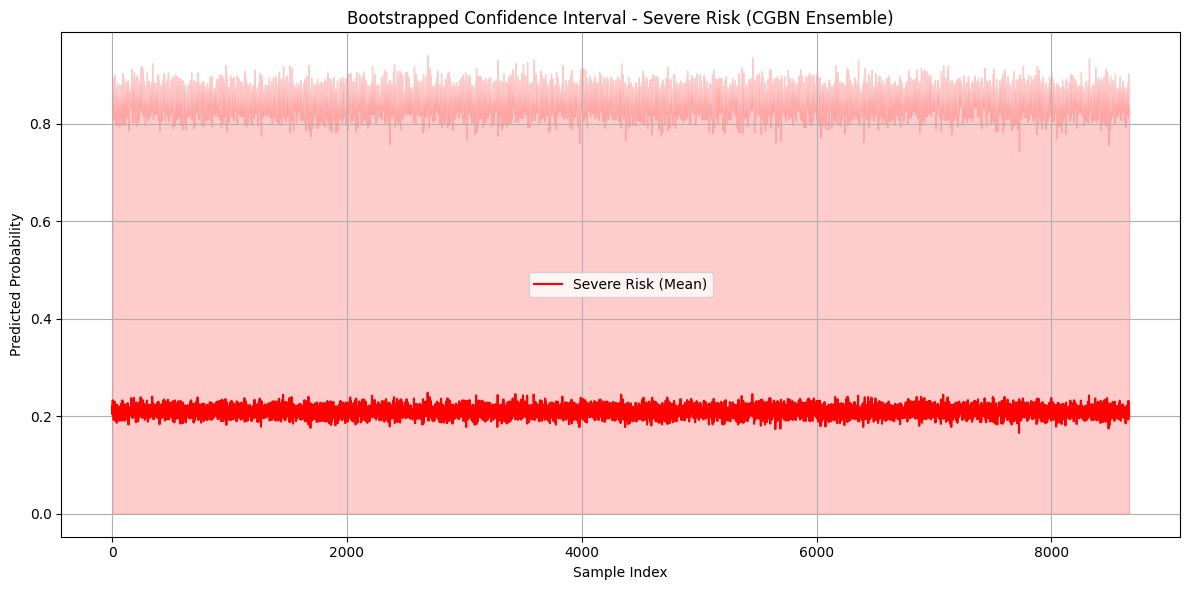

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mean_preds[:, 2], label="Severe Risk (Mean)", color="red")
plt.fill_between(range(min_len), lower_bound[:, 2], upper_bound[:, 2], alpha=0.2, color="red")
plt.title("Bootstrapped Confidence Interval - Severe Risk (CGBN Ensemble)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Comparison from adding ensemble
# Load both CI results if not in memory
ci1 = pd.read_csv("Ensemble2_Bootstrapped_CI_with_Metadata.csv")
ci2 = pd.read_csv("CGBN_Ensemble_Bootstrapped_CI_with_Metadata.csv")

# Compare median CI width by class
print("🔍 Median CI Width Comparison:")
print("Low:     ", ci1["Low CI Width"].median(), "→", ci2["Low CI Width"].median())
print("Moderate:", ci1["Moderate CI Width"].median(), "→", ci2["Moderate CI Width"].median())
print("Severe:  ", ci1["Severe CI Width"].median(), "→", ci2["Severe CI Width"].median())


🔍 Median CI Width Comparison:
Low:      1.0 → 1.0
Moderate: 1.0 → 1.0
Severe:   0.90452519 → 0.85005603
